In [1]:
pip install google-play-scraper

In [3]:
pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.6 MB/s eta 0:00:00


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Library to scrape Google Play
from google_play_scraper import Sort, reviews

from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

In [74]:
app_reviews = []
def reviews_scraper(app, score, n_loops):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]: # Collect both reviews types - 'most relevant' and 'newest'
        for i in range(n_loops):
            rvs, continuation_token = reviews(app,
                                              lang='vi',
                                              country='US',
                                              sort=sort_order,
                                              count=200, # 200 is the maximum number of reviews per page supported by Google Play
                                              filter_score_with=score,
                                              continuation_token=None if i==0 else continuation_token) # To begin crawling from where it last left off
            for r in rvs:
                r['sort_order'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                r['app_id'] = app
            app_reviews.extend(rvs)
            print('No. of reviews collected: ' + str(len(rvs)))

In [75]:
reviews_scraper(app='com.lazada.android', score=1, n_loops=5)

No. of reviews collected: 200
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 0


In [76]:
reviews_scraper(app='com.lazada.android', score=2, n_loops=5)

No. of reviews collected: 199
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 199
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 0


In [77]:
reviews_scraper(app='com.lazada.android', score=3, n_loops=5)

No. of reviews collected: 200
No. of reviews collected: 199
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 200
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 0


In [78]:
reviews_scraper(app='com.lazada.android', score=4, n_loops=5)

No. of reviews collected: 200
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 200
No. of reviews collected: 200
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 0


In [79]:
reviews_scraper(app='com.lazada.android', score=5, n_loops=5)

No. of reviews collected: 200
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 200
No. of reviews collected: 199
No. of reviews collected: 0
No. of reviews collected: 0
No. of reviews collected: 0


In [82]:
pd.DataFrame(app_reviews).to_csv('/content/data/lazada.csv', index=False)

In [132]:
reviews = pd.read_csv('/content/data/lazada.csv', parse_dates=['at','repliedAt'])

In [133]:
reviews.shape

(2796, 13)

In [134]:
reviews.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sort_order,app_id
0,a2e36fe8-8b49-4012-a777-33d1d6fd8ff8,沈沈,https://play-lh.googleusercontent.com/a-/ALV-U...,"giao hàng mẹ gì gọi thì k nhấc máy, r tự ý hủy...",1,3,7.47.0,2024-03-18 04:35:13,Lazada xin lỗi vì sự bất tiện. Nhằm giúp Lazad...,2024-03-18 04:56:54,7.47.0,most_relevant,com.lazada.android
1,11f7ddef-c5f6-4393-b5dc-27096efec218,vip khoa,https://play-lh.googleusercontent.com/a-/ALV-U...,"Ứng dụng tệ nhất thế giới, làm ăn toàn lừa nha...",1,62,7.47.0,2024-03-16 04:44:23,Lazada xin lỗi vì sự bất tiện. Nhằm giúp Lazad...,2024-03-16 04:53:41,7.47.0,most_relevant,com.lazada.android
2,6dbbd847-cf53-431c-a978-8a4f30b7324c,Thẻ Cào Miễn Phí,https://play-lh.googleusercontent.com/a-/ALV-U...,Đề nghị Lazada thêm tính năng Hủy đơn hàng khẩ...,1,288,7.47.0,2024-03-17 08:51:44,Lazada xin lỗi vì sự bất tiện. Nhằm giúp Lazad...,2024-03-17 08:53:09,7.47.0,most_relevant,com.lazada.android
3,b03b9d97-46fb-4020-acfa-d76db3fea713,Nhẫn Tâm,https://play-lh.googleusercontent.com/a/ACg8oc...,Lazada chơi mất dạy đơn đặt nhiệm vụ lazreward...,1,27,7.47.0,2024-03-17 03:23:39,Lazada xin lỗi vì sự bất tiện. Nhằm giúp Lazad...,2024-03-17 03:29:09,7.47.0,most_relevant,com.lazada.android
4,687ca28a-3c47-4349-9ffb-9afddfdf8010,Nguyên Nguyễn Thị,https://play-lh.googleusercontent.com/a/ACg8oc...,Làm event đặt 5 món trên 30k nhậ 80 laz reward...,1,41,7.47.0,2024-03-16 04:18:00,Lazada xin lỗi vì sự bất tiện. Nhằm giúp Lazad...,2024-03-16 04:54:09,7.47.0,most_relevant,com.lazada.android


In [135]:
df  = reviews.loc[:, ['content', 'score']]

In [136]:
df.head()

,content,score
0,"giao hàng mẹ gì gọi thì k nhấc máy, r tự ý hủy...",1
1,"Ứng dụng tệ nhất thế giới, làm ăn toàn lừa nha...",1
2,Đề nghị Lazada thêm tính năng Hủy đơn hàng khẩ...,1
3,Lazada chơi mất dạy đơn đặt nhiệm vụ lazreward...,1
4,Làm event đặt 5 món trên 30k nhậ 80 laz reward...,1


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2796 entries, 0 to 2795
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  2796 non-null   object
 1   score    2796 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.8+ KB


In [138]:
df['score'].value_counts()

1    600
4    600
3    599
5    599
2    398
Name: score, dtype: int64

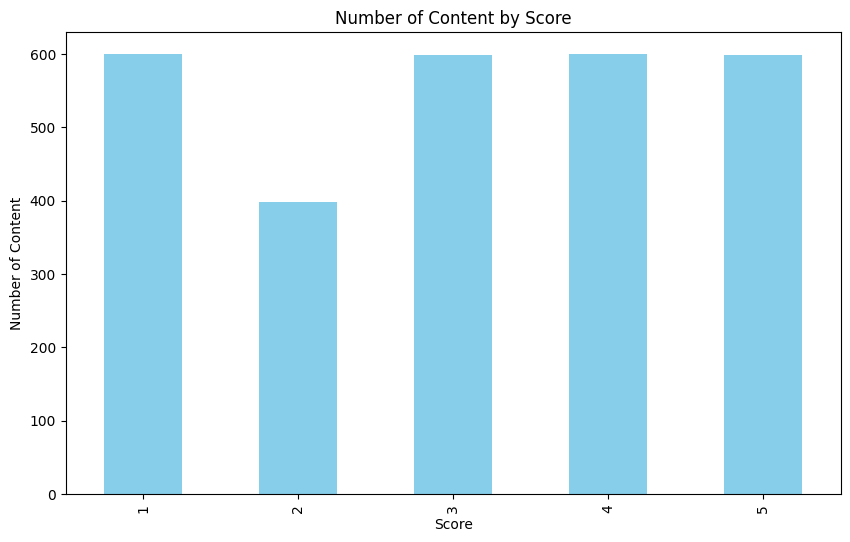

In [139]:
# Tính số lượng cột content cho mỗi mức score
count_content_by_score = df.groupby('score').size()


# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
count_content_by_score.plot(kind='bar', color='skyblue')
plt.xlabel('Score')
plt.ylabel('Number of Content')
plt.title('Number of Content by Score')
plt.show()

In [140]:
df['score'].value_counts().sort_index()

1    600
2    398
3    599
4    600
5    599
Name: score, dtype: int64

In [141]:
df[df.duplicated(['content'])].shape

(1143, 2)

In [142]:
df.drop_duplicates(['content'], inplace=True)

In [143]:
df.shape

(1653, 2)

In [144]:
df['score'].value_counts()

3    434
1    407
4    293
2    280
5    239
Name: score, dtype: int64

In [145]:
import unicodedata
import regex as re
from pyvi import ViTokenizer, ViPosTagger

In [146]:
bang_nguyen_am= [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]

bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']
nguyen_am_to_ids = {}

for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)

In [147]:
def chuan_hoa_unicode(text):
	text = unicodedata.normalize('NFC', text)
	return text

In [148]:
def chuan_hoa_dau_tu_tieng_viet(word):
    if not is_valid_vietnam_word(word):
        return word

    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            # for index2 in nguyen_am_index:
            #     if index2 != index:
            #         x, y = nguyen_am_to_ids[chars[index]]
            #         chars[index2] = bang_nguyen_am[x][0]
            return ''.join(chars)

    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            # chars[nguyen_am_index[1]] = bang_nguyen_am[x][0]
        else:
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
        # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[2]]]
        # chars[nguyen_am_index[2]] = bang_nguyen_am[x][0]
    return ''.join(chars)

def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True

In [149]:
def chuan_hoa_dau_cau_tieng_viet(sentence):
    """
        Chuyển câu tiếng việt về chuẩn gõ dấu kiểu cũ.
        :param sentence:
        :return:
        """
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        # print(cw)
        if len(cw) == 3:
            cw[1] = chuan_hoa_dau_tu_tieng_viet(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

In [150]:
def tach_tu_tieng_viet(text):
	text = ViTokenizer.tokenize(text)
	return text

# Đưa về chữ viết thường
def chuyen_chu_thuong(text):
	return text.lower()

# Xóa đi các dấu cách thừa, các từ không cần thiết cho việc phân loại vẳn bản
def chuan_hoa_cau(text):
	text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',text)
	text = re.sub(r'\s+', ' ', text).strip()
	return text

def tien_xu_li(text):
	text = chuan_hoa_unicode(text)
	text = chuan_hoa_dau_cau_tieng_viet(text)
	text = tach_tu_tieng_viet(text)
	text = chuyen_chu_thuong(text)
	text = chuan_hoa_cau(text)

	return text

In [151]:
df['content'] = df['content'].apply(tien_xu_li)

In [152]:
df.head()

,content,score
0,giao hàng mẹ gì gọi thì k nhấc máy r tự_ý_hủy ...,1
1,ứng_dụng tệ nhất thế_giới làm_ăn toàn lừa nhau...,1
2,đề_nghị lazada thêm tính_năng_hủy đơn hàng khẩ...,1
3,lazada chơi mất_dạy đơn đặt nhiệm_vụ lazreward...,1
4,làm event đặt 5 món trên 30k nhậ 80 laz reward...,1


In [153]:
df.to_csv('data.csv', index=False)